
# Vector Quantization

Spatial VQ using K-means.

In [1]:
%matplotlib inline

In [8]:
!ln -sf ~/repos/scalar_quantization/deadzone_quantizer.py .
!ln -sf ~/repos/scalar_quantization/distortion.py .
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .
!ln -sf ~/repos/scalar_quantization/information.py .

In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import cluster
import os
import pylab
import image_1 as gray_image
import distortion
import math

## Configuration

In [18]:
home = os.environ["HOME"]
fn = home + "/repos/MRVC/images/lena_bw/"
block_width = 16
block_height = 16
n_clusters = 256  # Number of bins
N_tries = 3  # Number of times K-means is run
#range_of_N_bins = range(2, 256, 1)
range_of_N_bins = [1<<i for i in range(1, 8)]
#gray_image.write = gray_image.debug_write # faster
gray_image.write = gray_image.write # higher compression

## Read the image and show it

[image_1.py:62 print_stats() INFO] max=245 min=25 avg=124.05046081542969


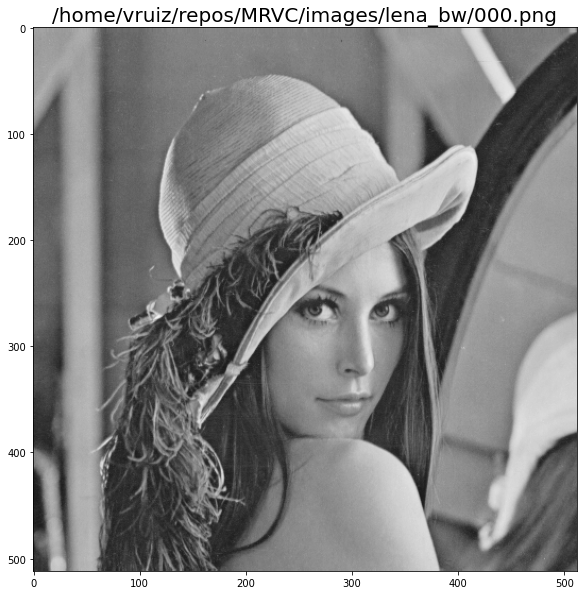

In [11]:
img = gray_image.read(fn, 0)
gray_image.show(img, fn + "000.png")

## Example

In [12]:
block_length = block_width*block_height
np.random.seed(seed=1)  # makes the random numbers predictable
k_means = cluster.KMeans(init="k-means++", n_clusters=n_clusters, n_init=N_tries)
blocks = []
for i in range(0, img.shape[0], block_width):
    for j in range(0, img.shape[1], block_height):
        blocks.append(np.reshape(img[i:i + block_width, j:j + block_height], block_length))
blocks = np.asarray(blocks).astype(float)
k_means.fit(blocks)
centroids = k_means.cluster_centers_.squeeze().astype(np.uint8)  # the code-book
labels = k_means.labels_  # Labels of the centroids

labels = labels.reshape(img.shape[0]//block_height, img.shape[1]//block_width)
img_dequantized = np.empty_like(img)
for i in range(0, img.shape[0], block_width):
    for j in range(0, img.shape[1], block_height):
        img_dequantized[i:i + block_width, j:j + block_height] = centroids[labels[i//block_width,j//block_height]].reshape(block_height, block_width)

[image_1.py:62 print_stats() INFO] max=245 min=26 avg=123.67221069335938


centroids =
 [[201 204 205 ... 208 208 206]
 [ 46  45  43 ... 113 112 107]
 [145 145 146 ... 143 143 143]
 ...
 [119 119 118 ... 168 160 157]
 [ 71  71  78 ... 161 168 171]
 [137 139 140 ... 196 194 193]]
256 centroids (8 bits/block)
32x32 blocks (vectors) in the image
total number of output bytes = 1024


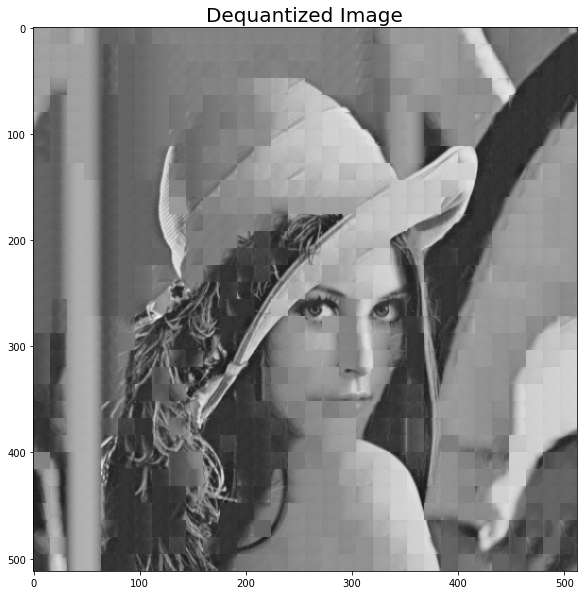

In [13]:
gray_image.show(img_dequantized, "Dequantized Image")
assert len(centroids) == n_clusters
print("centroids =\n", centroids)
bits_per_block = int(math.log(n_clusters)/math.log(2))
print(f"{len(centroids)} centroids ({bits_per_block} bits/block)")
blocks_in_y = img.shape[0]//block_height
blocks_in_x = img.shape[1]//block_width
print(f"{blocks_in_y}x{blocks_in_x} blocks (vectors) in the image")
number_of_blocks = blocks_in_y*blocks_in_x
total_number_of_bits = number_of_blocks*bits_per_block
print(f"total number of output bytes = {total_number_of_bits//8}")

In [17]:
def RD_curve(img, range_of_N_bins):
    blocks = []
    for i in range(0, img.shape[0], block_width):
        for j in range(0, img.shape[1], block_height):
            blocks.append(np.reshape(img[i:i + block_width, j:j + block_height], block_length))
    blocks = np.asarray(blocks).astype(float)
    points = []
    for n in range_of_N_bins:
        k_means = cluster.KMeans(init="k-means++", n_clusters=n, n_init=N_tries)
        k_means.fit(blocks)
        centroids = k_means.cluster_centers_.squeeze().astype(np.uint8)
        k = k_means.labels_.astype(np.uint8)  # bit-depth depends on number of bins! 
        k = k.reshape(img.shape[0]//block_height, img.shape[1]//block_width)
        y = np.empty_like(img)
        for i in range(0, img.shape[0], block_width):
            for j in range(0, img.shape[1], block_height):
                y[i:i + block_width, j:j + block_height] = centroids[k[i//block_width,j//block_height]].reshape(block_height, block_width)
        print("Quantization indexes: ", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/img.size
        _distortion = distortion.RMSE(img, y)
        if not n%10:
            plt.title(f"{n}")
            plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
            plt.show()
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points
RD_points = RD_curve(img, range_of_N_bins)

[image_1.py:36 debug_write() INFO] image_1.write: /tmp/2_000.png (32, 32) uint8 len=231 max=1 min=0
[image_1.py:36 debug_write() INFO] image_1.write: /tmp/4_000.png (32, 32) uint8 len=353 max=3 min=0
[image_1.py:36 debug_write() INFO] image_1.write: /tmp/8_000.png (32, 32) uint8 len=454 max=7 min=0
[image_1.py:36 debug_write() INFO] image_1.write: /tmp/16_000.png (32, 32) uint8 len=553 max=15 min=0


Quantization indexes:  [0 1]
n=  2, rate=0.007049560546875 bits/pixel, distortion=  32.2
Quantization indexes:  [0 1 2 3]
n=  4, rate=0.010772705078125 bits/pixel, distortion=  25.5
Quantization indexes:  [0 1 2 3 4 5 6 7]
n=  8, rate=0.01385498046875 bits/pixel, distortion=  21.9
Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
n= 16, rate=0.016876220703125 bits/pixel, distortion=  19.6


[image_1.py:36 debug_write() INFO] image_1.write: /tmp/32_000.png (32, 32) uint8 len=672 max=31 min=0


Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
n= 32, rate=0.0205078125 bits/pixel, distortion=  17.5


[image_1.py:36 debug_write() INFO] image_1.write: /tmp/64_000.png (32, 32) uint8 len=788 max=63 min=0


Quantization indexes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
n= 64, rate=0.0240478515625 bits/pixel, distortion=  15.1


[image_1.py:36 debug_write() INFO] image_1.write: /tmp/128_000.png (32, 32) uint8 len=960 max=127 min=0


Quantization indexes:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
n=128, rate=0.029296875 bits/pixel, distortion=  12.5


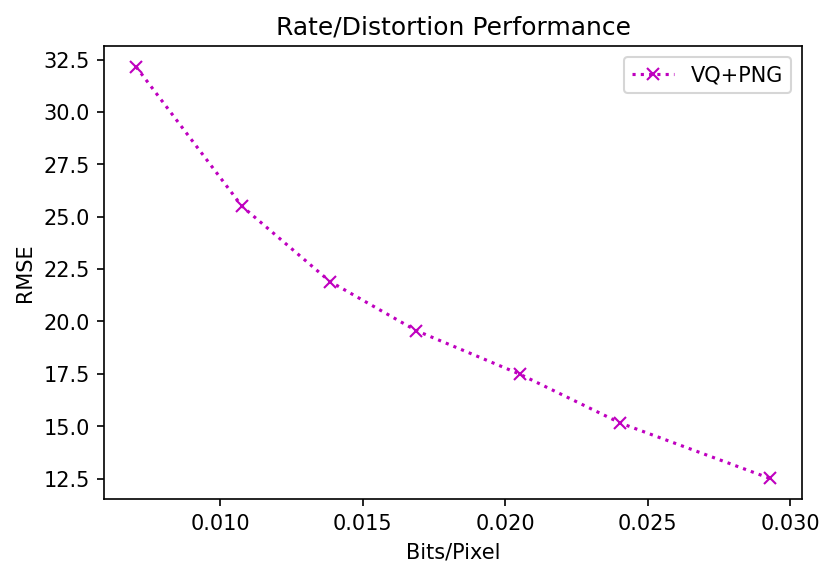

In [21]:
pylab.figure(dpi=150)
#pylab.scatter(*zip(*RD_points), label=f"VQ+PNG", s=1, marker='.')
pylab.plot(*zip(*RD_points), c='m', marker='x', label=f"VQ+PNG", linestyle="dotted")
pylab.title(f"Rate/Distortion Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

In [22]:
with open(f"VQ_RD_points.txt", 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")